In [1]:
%matplotlib inline
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output

# CNN : Convolutional Neural Network
畳み込みニューラルネットワークとも呼ばれ、局所的な情報の抽象化および位置普遍性を持たせて、順次伝搬型のニューラルネットワークを利用したアルゴリズム。画像に対して高いパターン認識能力を示す。<br>

### Conv2dについて
以下では5x5の画像を、kernel_size:3、stride:1のフィルタにて畳み込みをする場合を表している。
<div style="text-align: center;">
    
|入力画像|フィルタ（カーネル）|特徴マップ|
|:------:|:------------------:|:--------:|
|![入力画像](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.ap-northeast-1.amazonaws.com%2F0%2F75451%2F5b45b767-1e07-4102-28fb-abccc66235ae.png?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&w=1400&fit=max&s=c3d6f16fe0e4c64be2fe6008ab12fb1b)|![フィルタ](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.ap-northeast-1.amazonaws.com%2F0%2F75451%2F121ea662-1710-53f1-600b-1e5366d5e615.png?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&w=1400&fit=max&s=cae4658a23892486327e991dc888d0cf)|![](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.ap-northeast-1.amazonaws.com%2F0%2F75451%2F1473a519-d06a-f103-75bf-5638ef5ad340.gif?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&w=1400&fit=max&s=be18f7106495b38a3a221b2967fec737)
</div>

#### strideについて
何マスずつズラして計算するか？のズラす値を表している。
<div style="text-align: center;">

|stride:1|stride:2|
|:------:|:------:|
|![](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.ap-northeast-1.amazonaws.com%2F0%2F75451%2F754509b3-6d6c-ed32-1f7f-60738adcb501.gif?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&w=1400&fit=max&s=8eb57420ea53336ec9a21b2d1c6e76a0)|![](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.ap-northeast-1.amazonaws.com%2F0%2F75451%2F5a783ddf-db8c-e121-7b34-d4dc2c1367a2.gif?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&w=1400&fit=max&s=57599c36a551afcfdddd1300e257d5c7)|
</div>

### max_poolについて
`torch.nn.functional` : 誤差関数や活性化関数などの関数を持つモジュール（慣例として`F`という略称でインポートされる）。畳み込み層や線形層といった状態を持つモジュールの状態なし版レイヤーも同様にこのモジュールに含まれている。
`F.max_pool2d(input, kernel_size, stride=None, padding=0, dilation=1, ceil_mode=False, return_indices=False)`
- `input` : 入力Tensor（minibatch, channels, Height, Width）
- `kernel_size` : プーリング領域のサイズ。単一の数値またはタプルを指定できる。
- `stride` : プーリング領域のストライド。単一の数値またはタプルを指定できる。デフォでは`kernel_size`が入る
- `padding` : 両側に追加する暗黙的な負の無限大パディング。0以上`kernel_size`/2である必要がある
![F.max_pool2d](https://cdn-ak.f.st-hatena.com/images/fotolife/u/usagisagi/20180704/20180704212410.jpg)

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.loss_train_log = []
        self.loss_test_log = []
        self.acc_train_log = []
        self.acc_test_log = []
        
        # 1つの入力画像チャンネル、4 x 4の正方形畳み込み、32つの出力チャンネル
        self.Conv1 = nn.Conv2d( 1, 32, kernel_size = (4, 4), stride = (2, 2), padding = 1)
        # 32つの入力画像チャンネル、4 x 4の正方形畳み込み、64つの出力チャンネル
        self.Conv2 = nn.Conv2d(32, 64, kernel_size = (4, 4), stride = (2, 2), padding = 1)
        self.linear1 = nn.Linear(64 * 3 * 3, 128)
        self.linear2 = nn.Linear(128, 10)
        
        # 誤差関数の設定
        self.loss = nn.CrossEntropyLoss() 
        # 最適化手法の設定
        self.optimizer = optim.SGD(self.parameters(), lr = 1e-2)
        
    def forward(self, x):
        x = self.Conv1(x) # Size : 1 x 28 x 28 -> 32 x 14 x 14
        x = torch.relu(x)
        x = self.Conv2(x) # Size : 32 x 14 x 14 -> 64 x 7 x 7
        x = torch.relu(x)
        x = F.max_pool2d(x, 2) # 指定サイズの範囲内で最大の値を抽出する(Size : 64 x 7 x 7 -> 64 x 3 x 3)
        x = x.view(-1, 64 * 3 * 3) # ベクトルに変換
        x = self.linear1(x)
        x = torch.relu(x)
        return self.linear2(x)
    
model = CNN()
# モデルの表示
print(model)

CNN(
  (Conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (Conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (linear1): Linear(in_features=576, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (loss): CrossEntropyLoss()
)


## データセットの読み込み

In [3]:
train_data = torchvision.datasets.MNIST(
    root = "../data",
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
test_data = torchvision.datasets.MNIST(
    root = "../data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

Image batch shape [batch_size : 64, color : 1, width : 28, height : 28]
Labels batch shape : 64


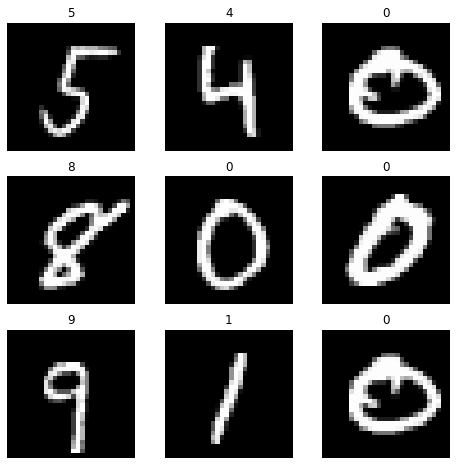

In [4]:
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)
# 辞書型変数にまとめると学習・検証の実施時に扱いやすくなる
dataloaders_dict = {"train" : train_dataloader, "test" : test_dataloader}
# イテレータに変換
batch_iterator = iter(dataloaders_dict["train"])
# 要素を取り出す
imgs, labels = next(batch_iterator)
print("Image batch shape [batch_size : %d, color : %d, width : %d, height : %d]"
      % (imgs.size()[0], imgs.size()[1], imgs.size()[2], imgs.size()[3]))
print(f"Labels batch shape : {labels.size()[0]}")

# 訓練データの表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 3, 3
for i in range(rows * cols):
    idx = torch.randint(low = 0, high = len(imgs), size = (1, 1)).item()
    # データの取得
    img, label = imgs[idx], labels[idx]
    figure.add_subplot(cols, rows, i + 1)
    plt.title(label.item())
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap = "gray")
plt.show()

# モデルの学習と評価

epoch : 1
loss_train : 1.7157561300850626, acc_train : 0.5128764510154724
loss_test  : 0.5189200937747955, acc_test : 0.8587778806686401
epoch : 10
loss_train : 0.08265358053479416, acc_train : 0.9750133156776428
loss_test  : 0.07543858100072878, acc_test : 0.9742237329483032
epoch : 20
loss_train : 0.04847274371348361, acc_train : 0.9850746393203735
loss_test  : 0.04925927235507614, acc_test : 0.984175980091095


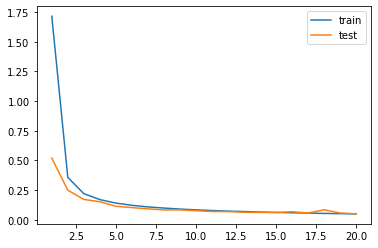

In [5]:
for epoch in range(20): # エポック数分ループを回す
    loss_train = 0.0
    acc_train = 0.0
    loss_test = 0.0
    acc_test = 0.0
    
    # 学習
    for (x, t) in train_dataloader:
        # パラメータの勾配をリセット
        model.optimizer.zero_grad()
        # 順伝搬＋逆伝搬＋パラメータ更新
        y = model(x)
        loss = model.loss(y, t)
        loss.backward()
        model.optimizer.step()
        # 統計情報の記録
        loss_train += loss.item()
        acc_train += sum(y.argmax(axis=1) == t) / len(t)
        
    # 検証
    with torch.no_grad(): # テストでは勾配を求める必要がないので、勾配を求めないように設定
        for x, t in test_dataloader:
            y = model(x)
            loss = model.loss(y, t)
            loss_test += loss.item()
            acc_test += sum(y.argmax(axis=1) == t) / len(t)
            
    # 結果の記録・表示
    model.loss_train_log.append(loss_train / len(train_dataloader))
    model.loss_test_log.append(loss_test / len(test_dataloader))
    if epoch == 0 or epoch % 10 == 9:
        print(f"epoch : {epoch + 1}")
        print(f"loss_train : {loss_train / len(train_dataloader)}, acc_train : {acc_train / len(train_dataloader)}")
        print(f"loss_test  : {loss_test / len(test_dataloader)}, acc_test : {acc_test / len(test_dataloader)}")
        
# Lossのログ表示
plt.plot(range(1, len(model.loss_train_log) + 1), model.loss_train_log, label = "train")
plt.plot(range(1, len(model.loss_test_log) + 1),  model.loss_test_log,  label = "test")
plt.legend(loc = "upper right") # 凡例表示

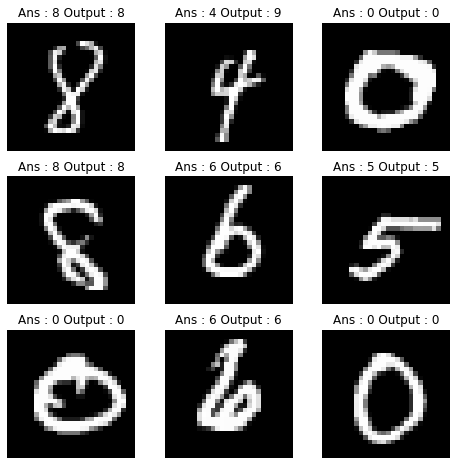

In [6]:
# 推論結果の表示
figure = plt.figure(figsize = (8, 8))
rows, cols = 3, 3
for i in range(rows * cols):
    idx = torch.randint(low = 0, high = len(imgs), size = (1, 1)).item()
    # データの取得
    img, label = imgs[idx], labels[idx]
    figure.add_subplot(cols, rows, i + 1)
    plt.title(f"Ans : {label.item()} Output : {model(img).argmax(axis=1).item()}")
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap = "gray")
plt.show()